# 4. Confusion matrix

## 1. Best learned models

In [1]:
import glob
import pandas as pd

# Load data
files = glob.glob('../evaluate_results/outer/*.csv', recursive=True)

print(len(files), 'files')
data = pd.concat([pd.read_csv(file, index_col=[0]) for file in files])

# Filter metric
data_sorted = data[data['metric'] == 'accuracy']

# Mean and sort values
data_sorted = data_sorted.groupby(['model', 'best_params', 'split_method', 'i_outer', 'metric']) \
    .mean() \
    .sort_values('value', ascending=False) \
    [['value']]

# Maintain only best params
data_sorted = data_sorted.reset_index(['best_params', 'split_method', 'i_outer'])
data_sorted = data_sorted[~data_sorted.index.duplicated(keep='first')]

# Reindex
data_sorted.reset_index().set_index(['model', 'best_params', 'metric', 'split_method', 'i_outer'])

140 files


,,,,,value
model,best_params,metric,split_method,i_outer,
SVC,"{'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}",accuracy,split_x_y_split_with_one_hot_encoding,1,0.409722
LogisticRegression,{},accuracy,split_x_y_split_with_one_hot_encoding,0,0.404157
KNeighborsClassifier,"{'algorithm': 'brute', 'metric': 'hamming', 'n_neighbors': 25}",accuracy,split_x_y,1,0.373843
MLPClassifier,"{'hidden_layer_sizes': 80, 'max_iter': 500}",accuracy,split_x_y_split_with_one_hot_encoding,0,0.369900


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

from experiments.model_evaluate.split_method import split_x_y, split_with_one_hot_encoding_function


n_labels = 117

models = [
    [KNeighborsClassifier, 1, {'algorithm': 'brute', 'metric': 'hamming', 'n_neighbors': 25}, split_x_y],
    [svm.SVC, 1, {'C': 10.0, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}, split_with_one_hot_encoding_function(n_labels)],
    [LogisticRegression, 0, {'multi_class': 'auto', 'solver': 'liblinear'}, split_with_one_hot_encoding_function(n_labels)],
    [MLPClassifier, 0, {'hidden_layer_sizes': 80, 'max_iter': 500}, split_with_one_hot_encoding_function(n_labels)],
]

## 2. Plot confusion matrix

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [30, 25]#[14, 10]

import numpy as np
import pandas as pd

import seaborn as sns

from rbm.train.kfold_elements import KFoldElements

from experiments.other_models.utils import plot_confusion_matrix

In [4]:
def train(Model, kfold, params, split_method):
    data = pd.read_csv('../data/patches-filtered.csv', sep=",", index_col=['id', 'name'])
    
    kfolds = KFoldElements(data=data, n_splits=5, random_state=42, shuffle=False)

    model = Model(**params)

    for index, train, test in kfolds.split():
        if index != kfold:
            continue

        ys = []
        y_predicts = []

        for column in range(0, 6):
            X, y = split_method(train, column)

            model.fit(X, y)
            X_test, y_test = split_method(test, column)

            ys.append(y_test)
            y_predicts.append(model.predict(X_test))

        break
    
    return ys, y_predicts

In [14]:
categories = pd.read_csv('../data/plugins_categories_simplified.csv').sort_values(['category', 'name'])
categories_order = ['Pedal Fx', 'Dynamics', 'Modulation', 'SFX', 'Filter_EQ', 'Amp', 'Stomp', 'Delay', 'Reverb', 'Combination Fx', 'None']

categories['new_id'] = categories.category + '.' + categories.id.astype(str).str.rjust(3, '0')

categories['new_new_id'] = pd.concat([f'{i-1}.' + categories['new_id'][categories['new_id'].str.startswith(category_name)] for i, category_name in enumerate(categories_order)])

categories = categories.sort_values('new_new_id')
categories.head(5)

,id,name,category,new_id,new_new_id
111,67,PedalVx,Pedal Fx,Pedal Fx.067,-1.Pedal Fx.067
112,68,PedalCry,Pedal Fx,Pedal Fx.068,-1.Pedal Fx.068
114,69,PDL Pitch,Pedal Fx,Pedal Fx.069,-1.Pedal Fx.069
115,70,PDL MnPit,Pedal Fx,Pedal Fx.070,-1.Pedal Fx.070
0,23,Comp,Dynamics,Dynamics.023,0.Dynamics.023


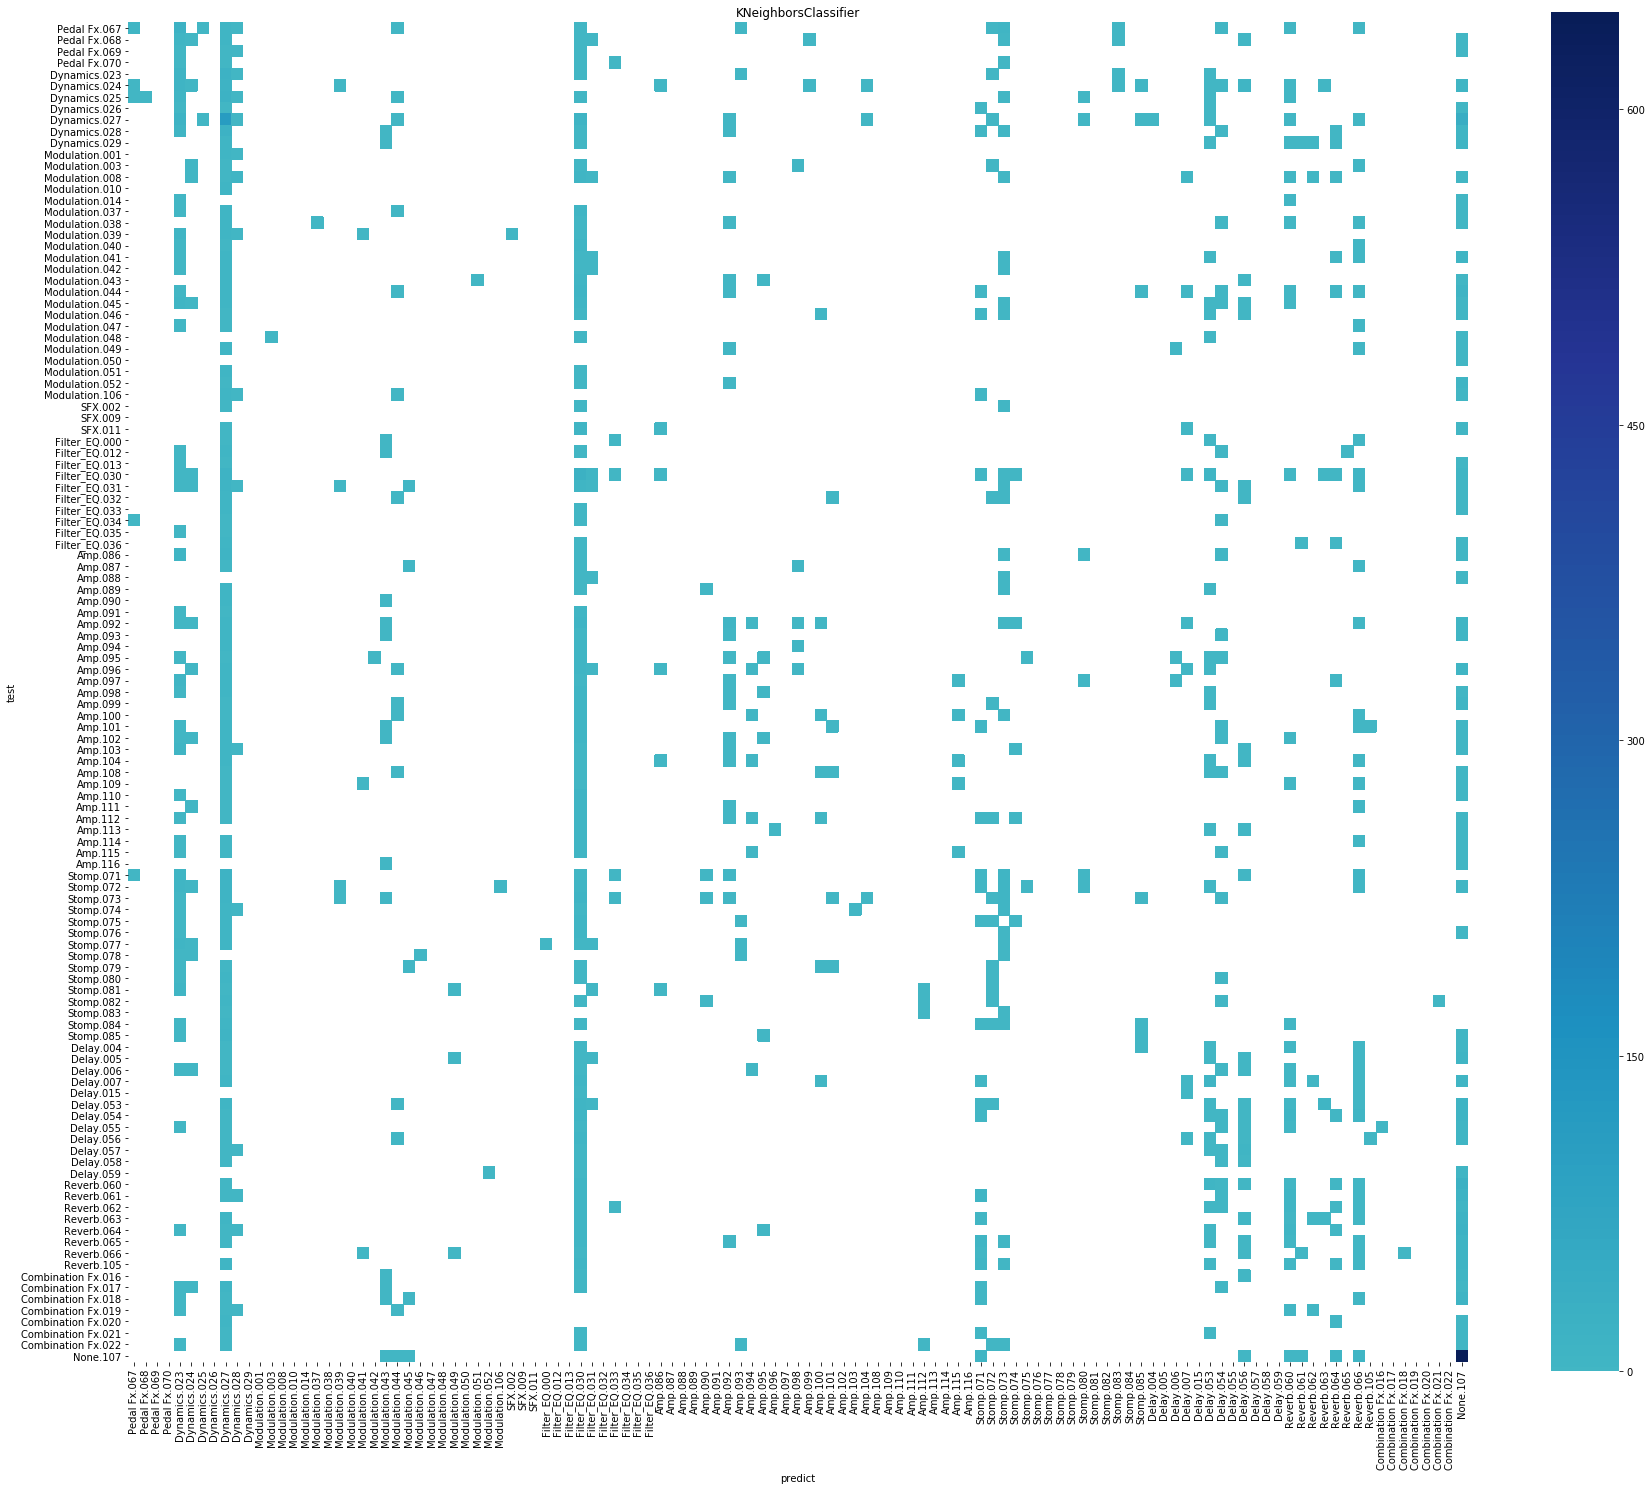

In [6]:
ys, y_predicts = train(*models[0])
plot_confusion_matrix(models[0][0].__name__, ys, y_predicts, categories.id, categories.new_id)

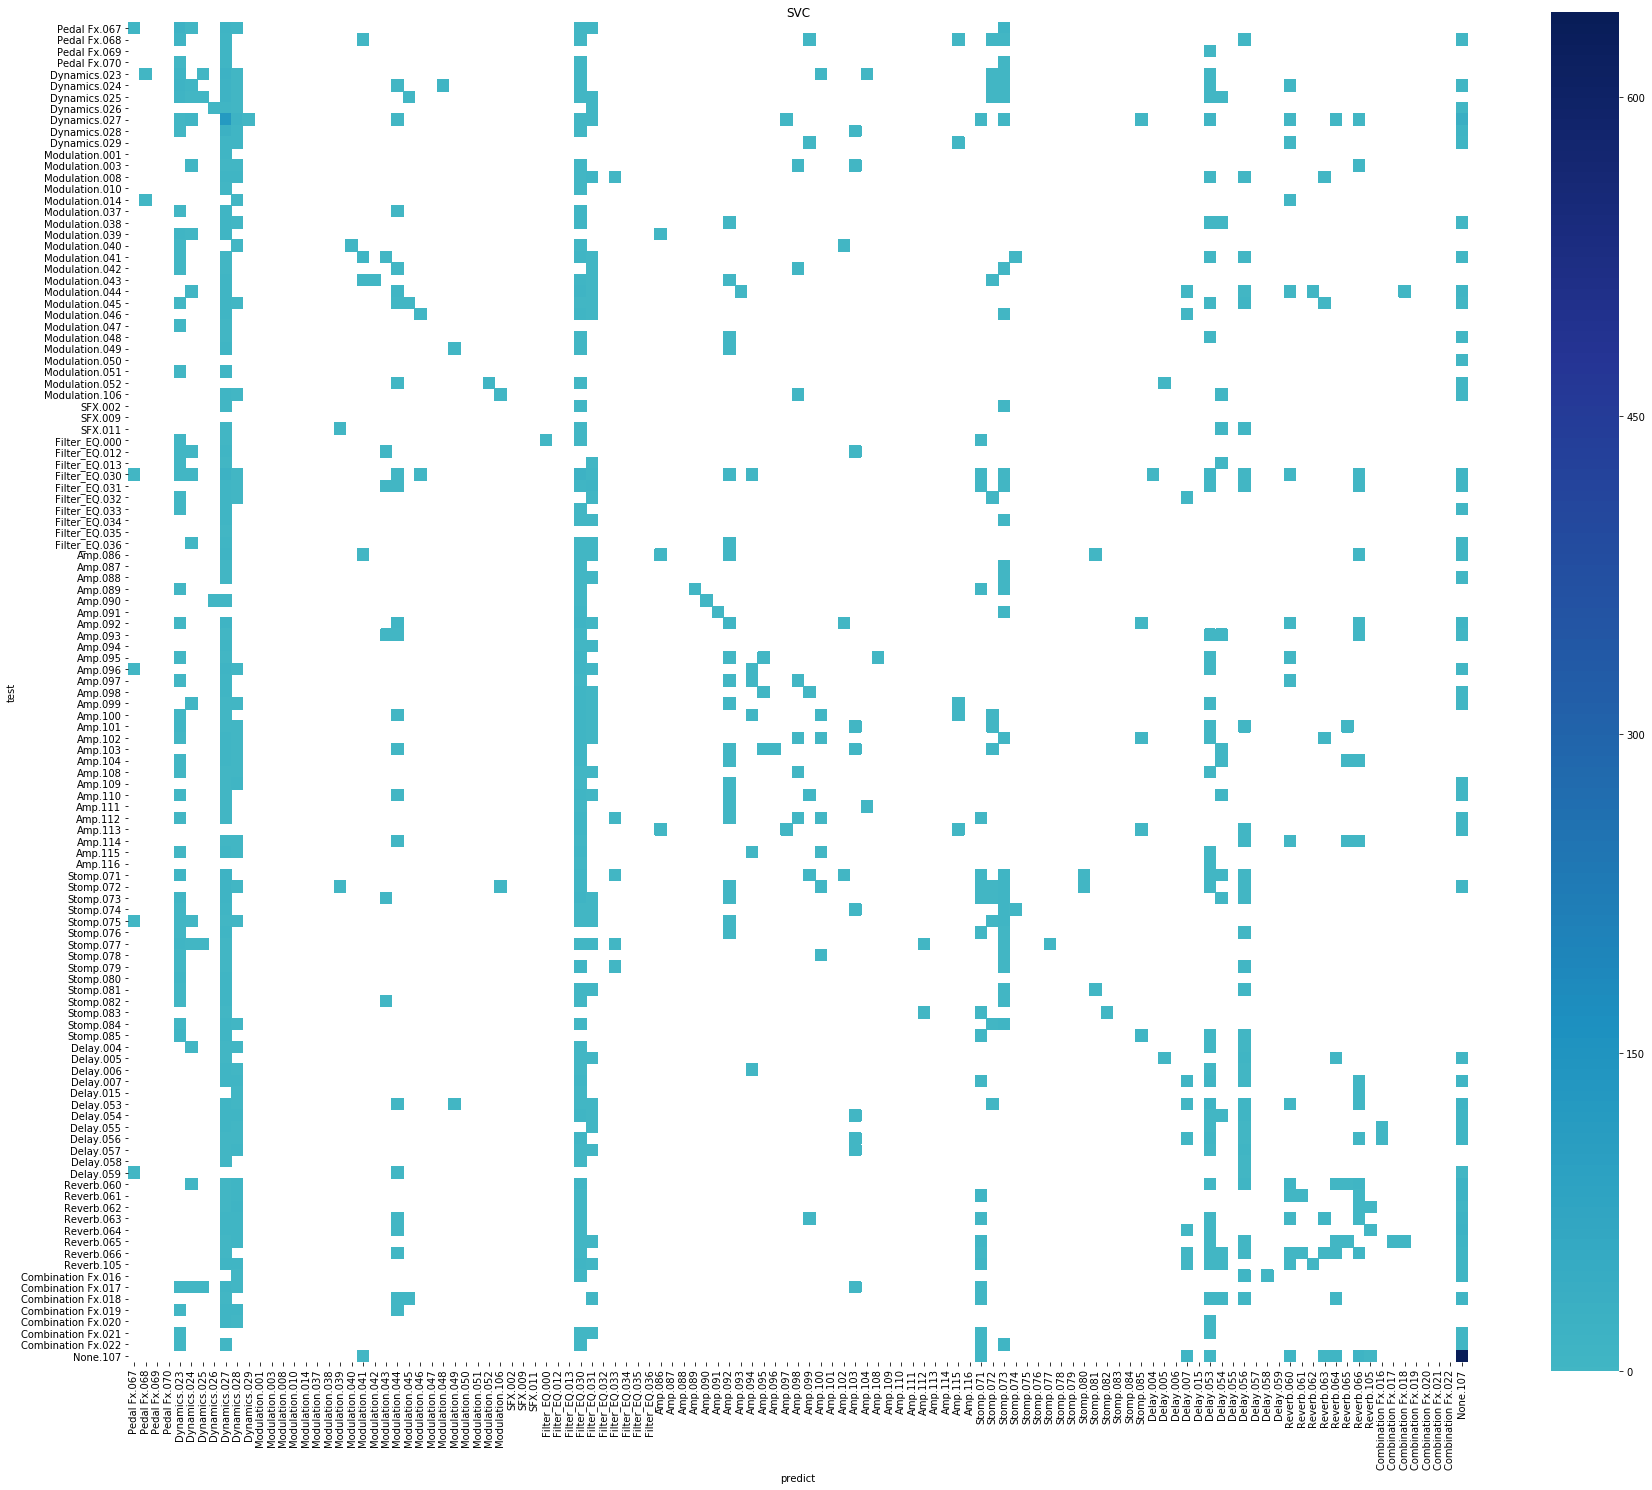

In [7]:
ys, y_predicts = train(*models[1])
plot_confusion_matrix(models[1][0].__name__, ys, y_predicts, categories.id, categories.new_id)

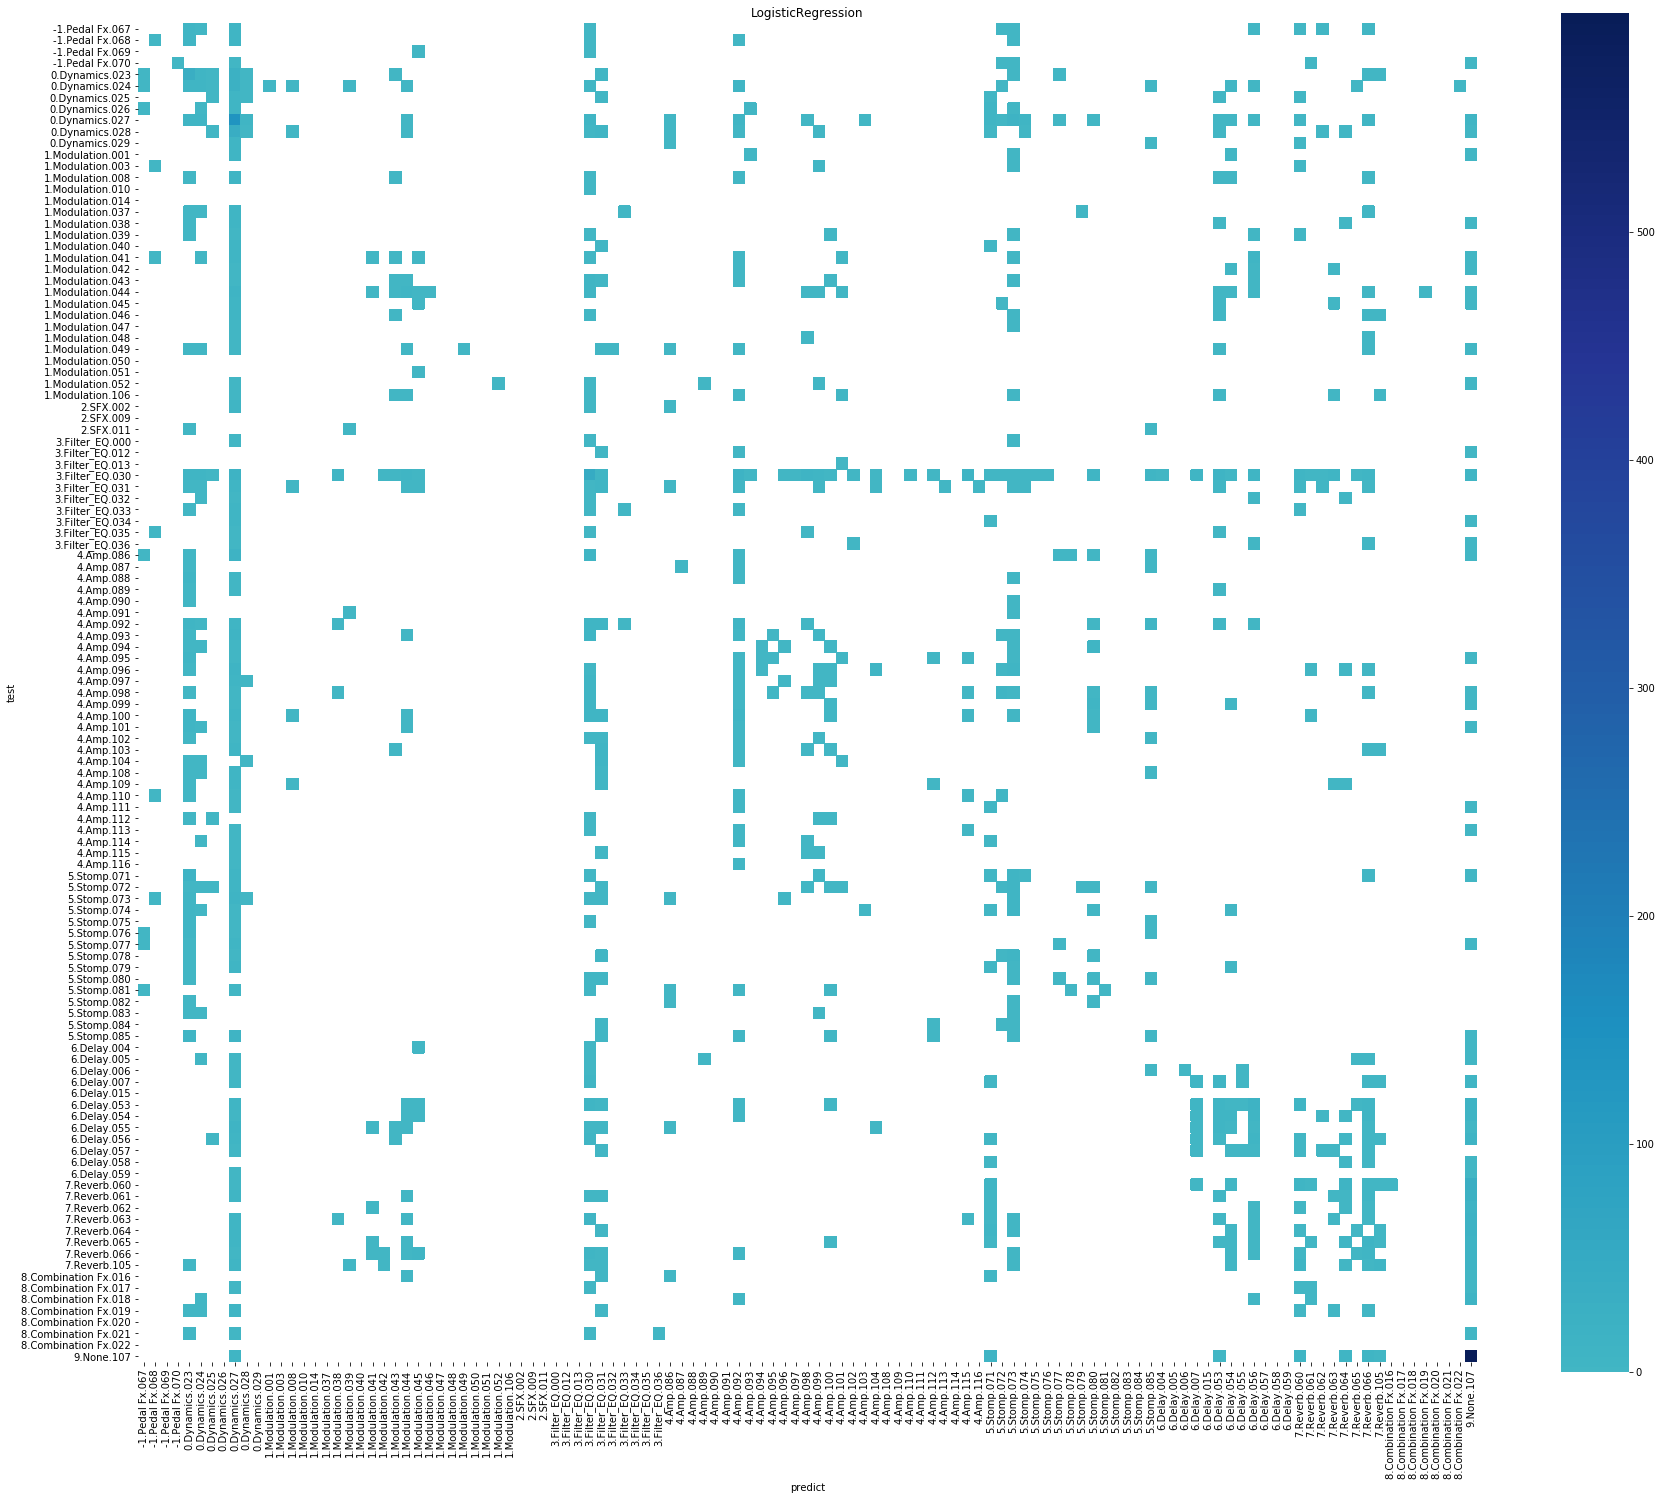

In [8]:
ys, y_predicts = train(*models[2])
ax = plot_confusion_matrix(models[2][0].__name__, ys, y_predicts, categories.id, categories.new_id)

/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.2-py3.6-linux-x86_64.egg/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.2-py3.6-linux-x86_64.egg/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.2-py3.6-linux-x86_64.egg/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/paulo/git/RBM/venv/lib/python3.6/site-packages/scikit_learn-0.20.2-py3.6-lin

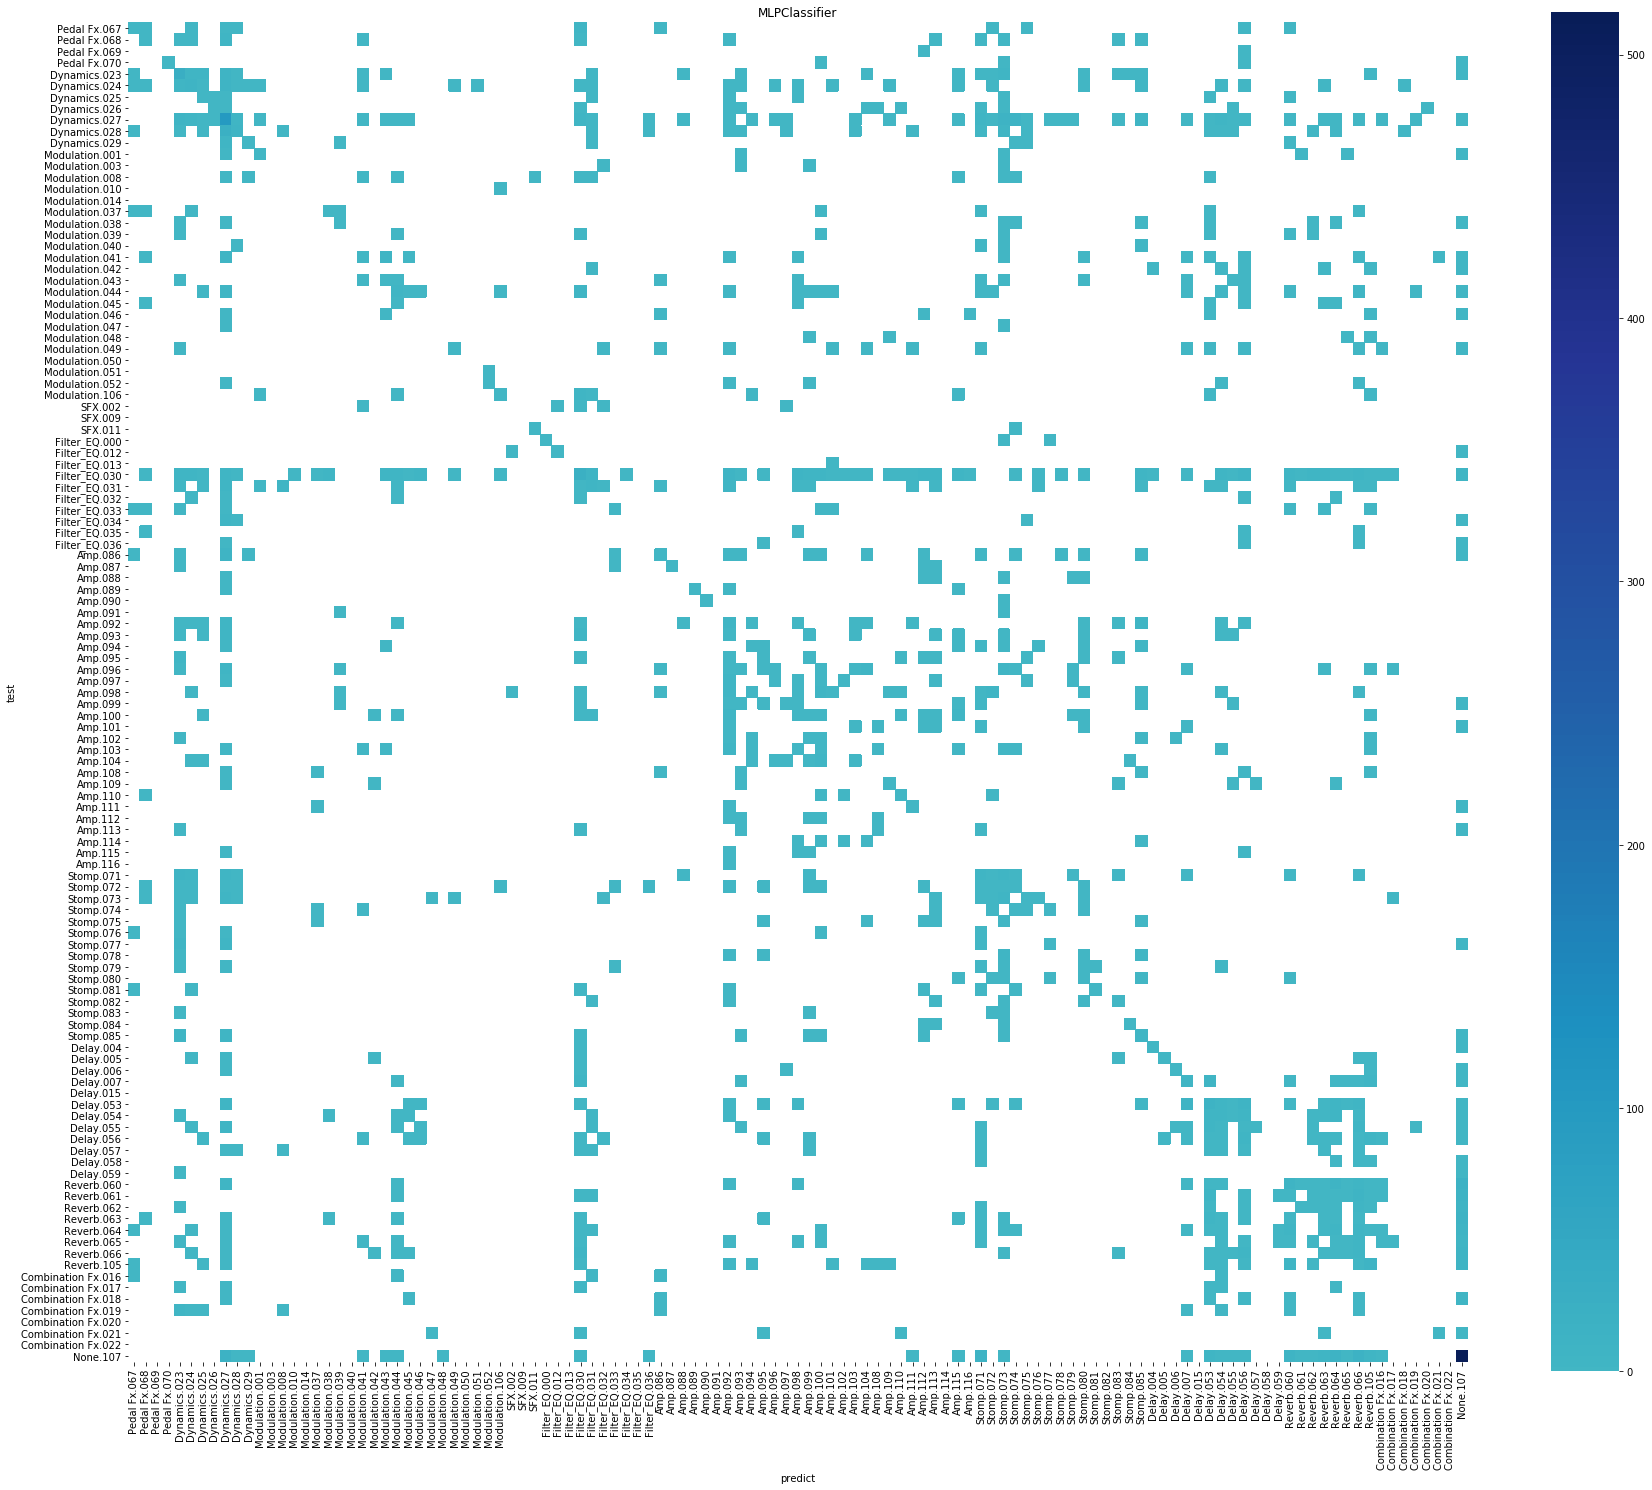

In [9]:
ys, y_predicts = train(*models[3])
ax = plot_confusion_matrix(models[3][0].__name__, ys, y_predicts, categories.id, categories.new_id)

## Probabilistic Graphical Models

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle

from experiments.rbm_experiment.rbm_experiment import RBMExperiment
from rbm.learning.adam import Adam
from rbm.rbmcf import RBMCF
from rbm.rbm import RBM
from rbm.train.kfold_elements import KFoldElements
from experiments.rbm_experiment.data import Data


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [15]:
original_bag_of_plugins = pd.read_csv('../data/patches-one-hot-encoding.csv', sep=",", index_col=['index', 'id'], dtype=np.float32)
bag_of_plugins = shuffle(original_bag_of_plugins, random_state=42)
kfolds_training_test = KFoldElements(data=bag_of_plugins, n_splits=5, random_state=42, shuffle=False)

total_movies = 6

def plot_rbm_model(Model: 'Callable', batch_size):
    for i, X_trian, X_test in kfolds_training_test.split():
        tf.reset_default_graph()

        with tf.Session() as session:
            model = Model()
            model.load(session, f"../results/model/kfold={i}+kfold-intern=0+batch_size={batch_size}+{model.__str__().replace('/', '+')}/rbm.ckpt")
            model = RBMExperiment(model, total_movies)

            ys = []
            y_predicts = []

            for i in range(total_movies):
                X, y = Data(X_test.values, total_movies).to_missing_movie(i)

                ys.append(y.argmax(axis=1))
                y_predicts.append(session.run(model.predict(X.T, y_column=i)))
        break

    print("Verificar se está transposto")
    plot_confusion_matrix(model.model.__class__.__name__, ys, y_predicts, categories.id, categories.new_id)

Best RBMCF RMSE
INFO:tensorflow:Restoring parameters from ../results/model/kfold=0+kfold-intern=0+batch_size=64+class=RBMCF+visible_size=702+hidden_size=500+regularization=NoRegularization-0.0+learning_rate=Adam-0.05-0.9-0.999-1e-08+sampling_method=CD-1+momentum=0/rbm.ckpt
Verificar se está transposto


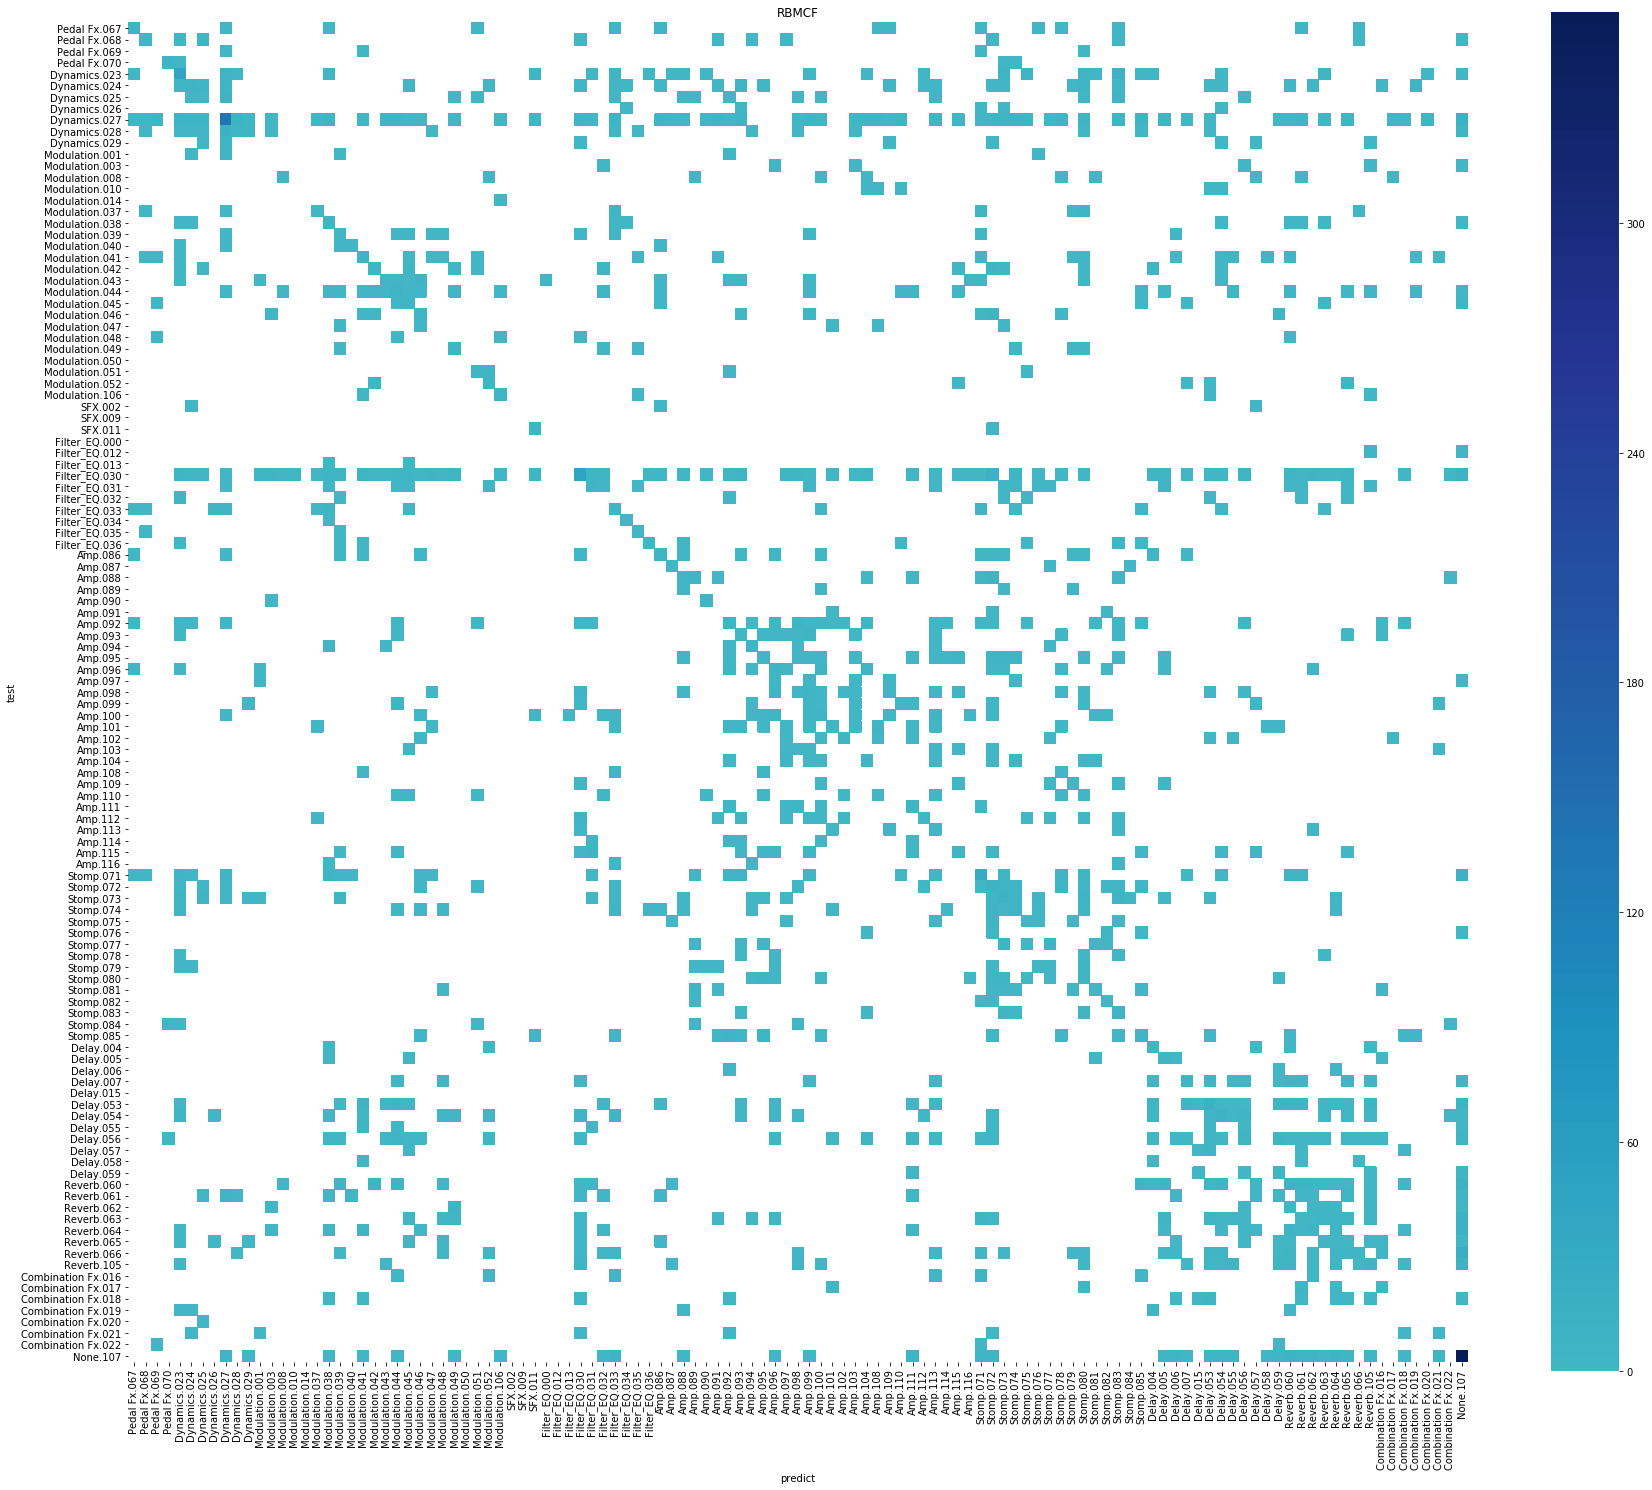

In [17]:
print("Best RBMCF RMSE")
model = lambda: RBMCF(total_movies, n_labels, hidden_size=500, learning_rate=Adam(0.05), momentum=0)
plot_rbm_model(model, batch_size=64)

Best RBM RMSE
INFO:tensorflow:Restoring parameters from ../results/model/kfold=0+kfold-intern=0+batch_size=64+class=RBM+visible_size=702+hidden_size=500+regularization=NoRegularization-0.0+learning_rate=Adam-0.05-0.9-0.999-1e-08+sampling_method=CD-1+momentum=0/rbm.ckpt
Verificar se está transposto


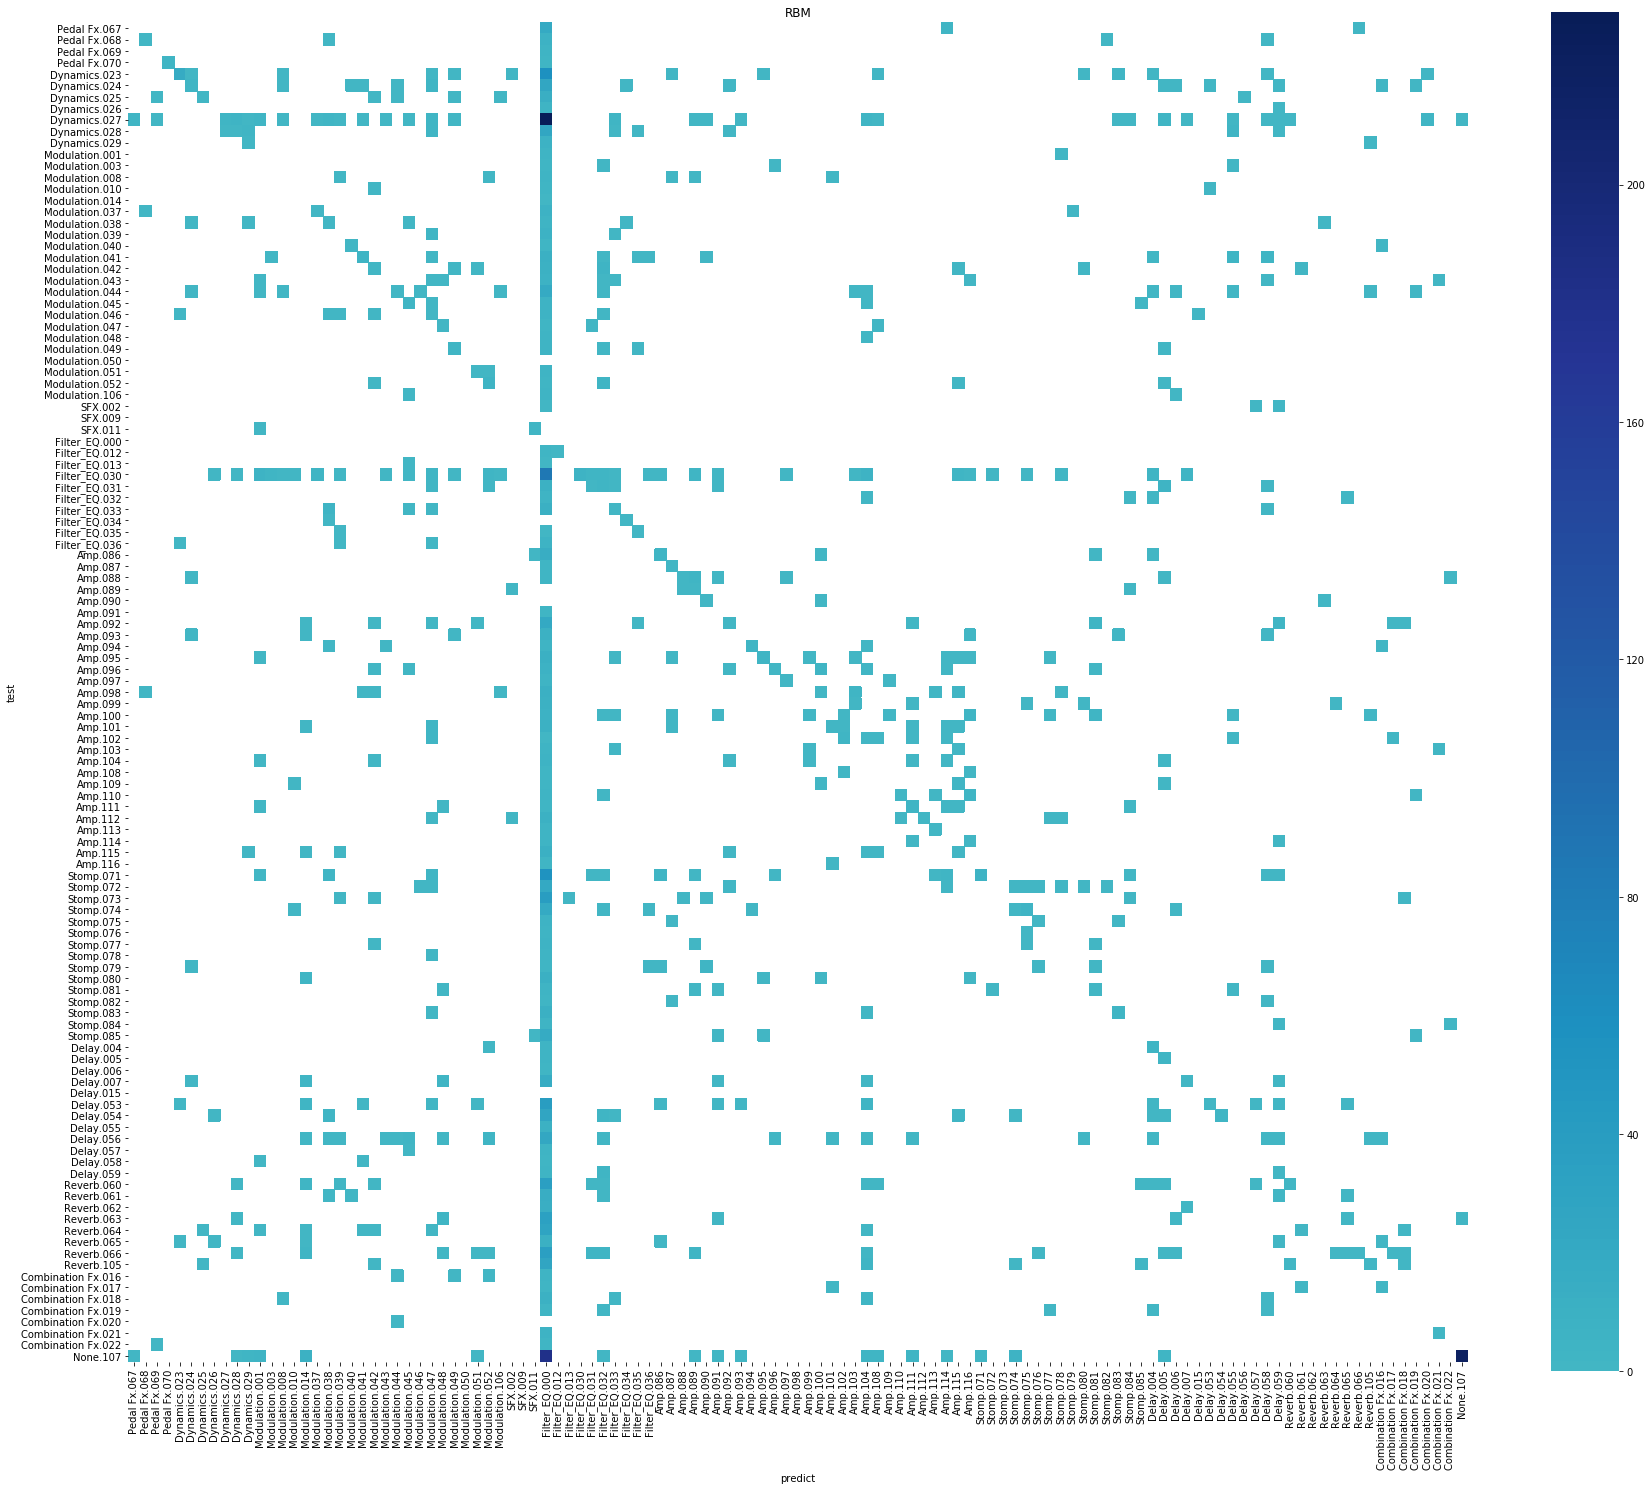

In [19]:
print("Best RBM RMSE")
model = lambda: RBM(visible_size=total_movies*n_labels, hidden_size=500, learning_rate=Adam(0.05), momentum=0)
plot_rbm_model(model, batch_size=64)

Best RBMCF Free Energy GAP
INFO:tensorflow:Restoring parameters from ../results/model/kfold=0+kfold-intern=0+batch_size=100+class=RBMCF+visible_size=702+hidden_size=500+regularization=NoRegularization-0.0+learning_rate=Adam-0.05-0.9-0.999-1e-08+sampling_method=CD-1+momentum=0/rbm.ckpt
Verificar se está transposto


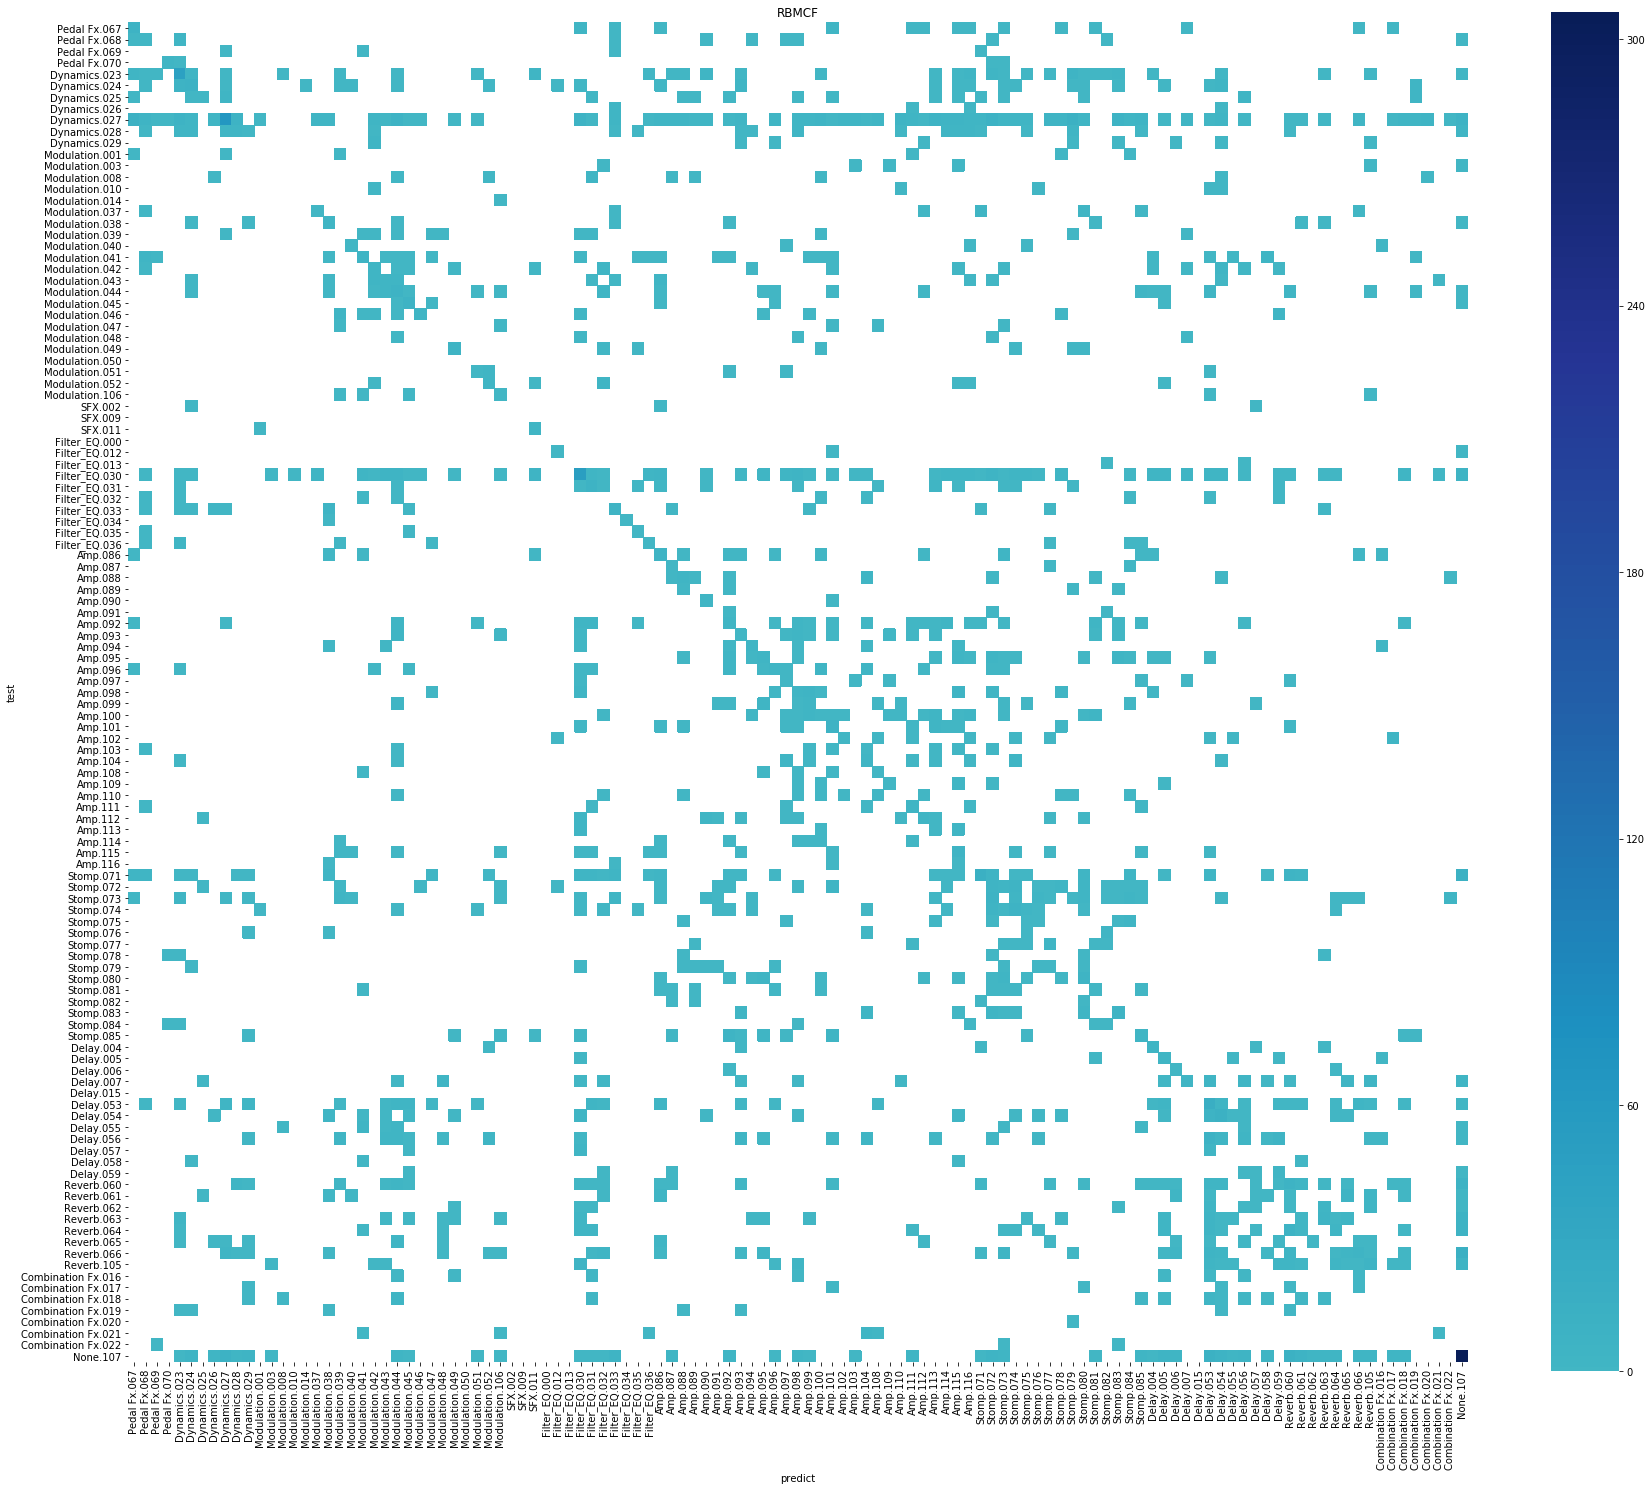

In [20]:
print("Best RBMCF Free Energy GAP")
model = lambda: RBMCF(total_movies, n_labels, hidden_size=500, learning_rate=Adam(0.05), momentum=0)
plot_rbm_model(model, batch_size=100)

Best RBM Free Energy Gap
INFO:tensorflow:Restoring parameters from ../results/model/kfold=0+kfold-intern=0+batch_size=100+class=RBM+visible_size=702+hidden_size=500+regularization=NoRegularization-0.0+learning_rate=Adam-0.05-0.9-0.999-1e-08+sampling_method=CD-1+momentum=0/rbm.ckpt
Verificar se está transposto


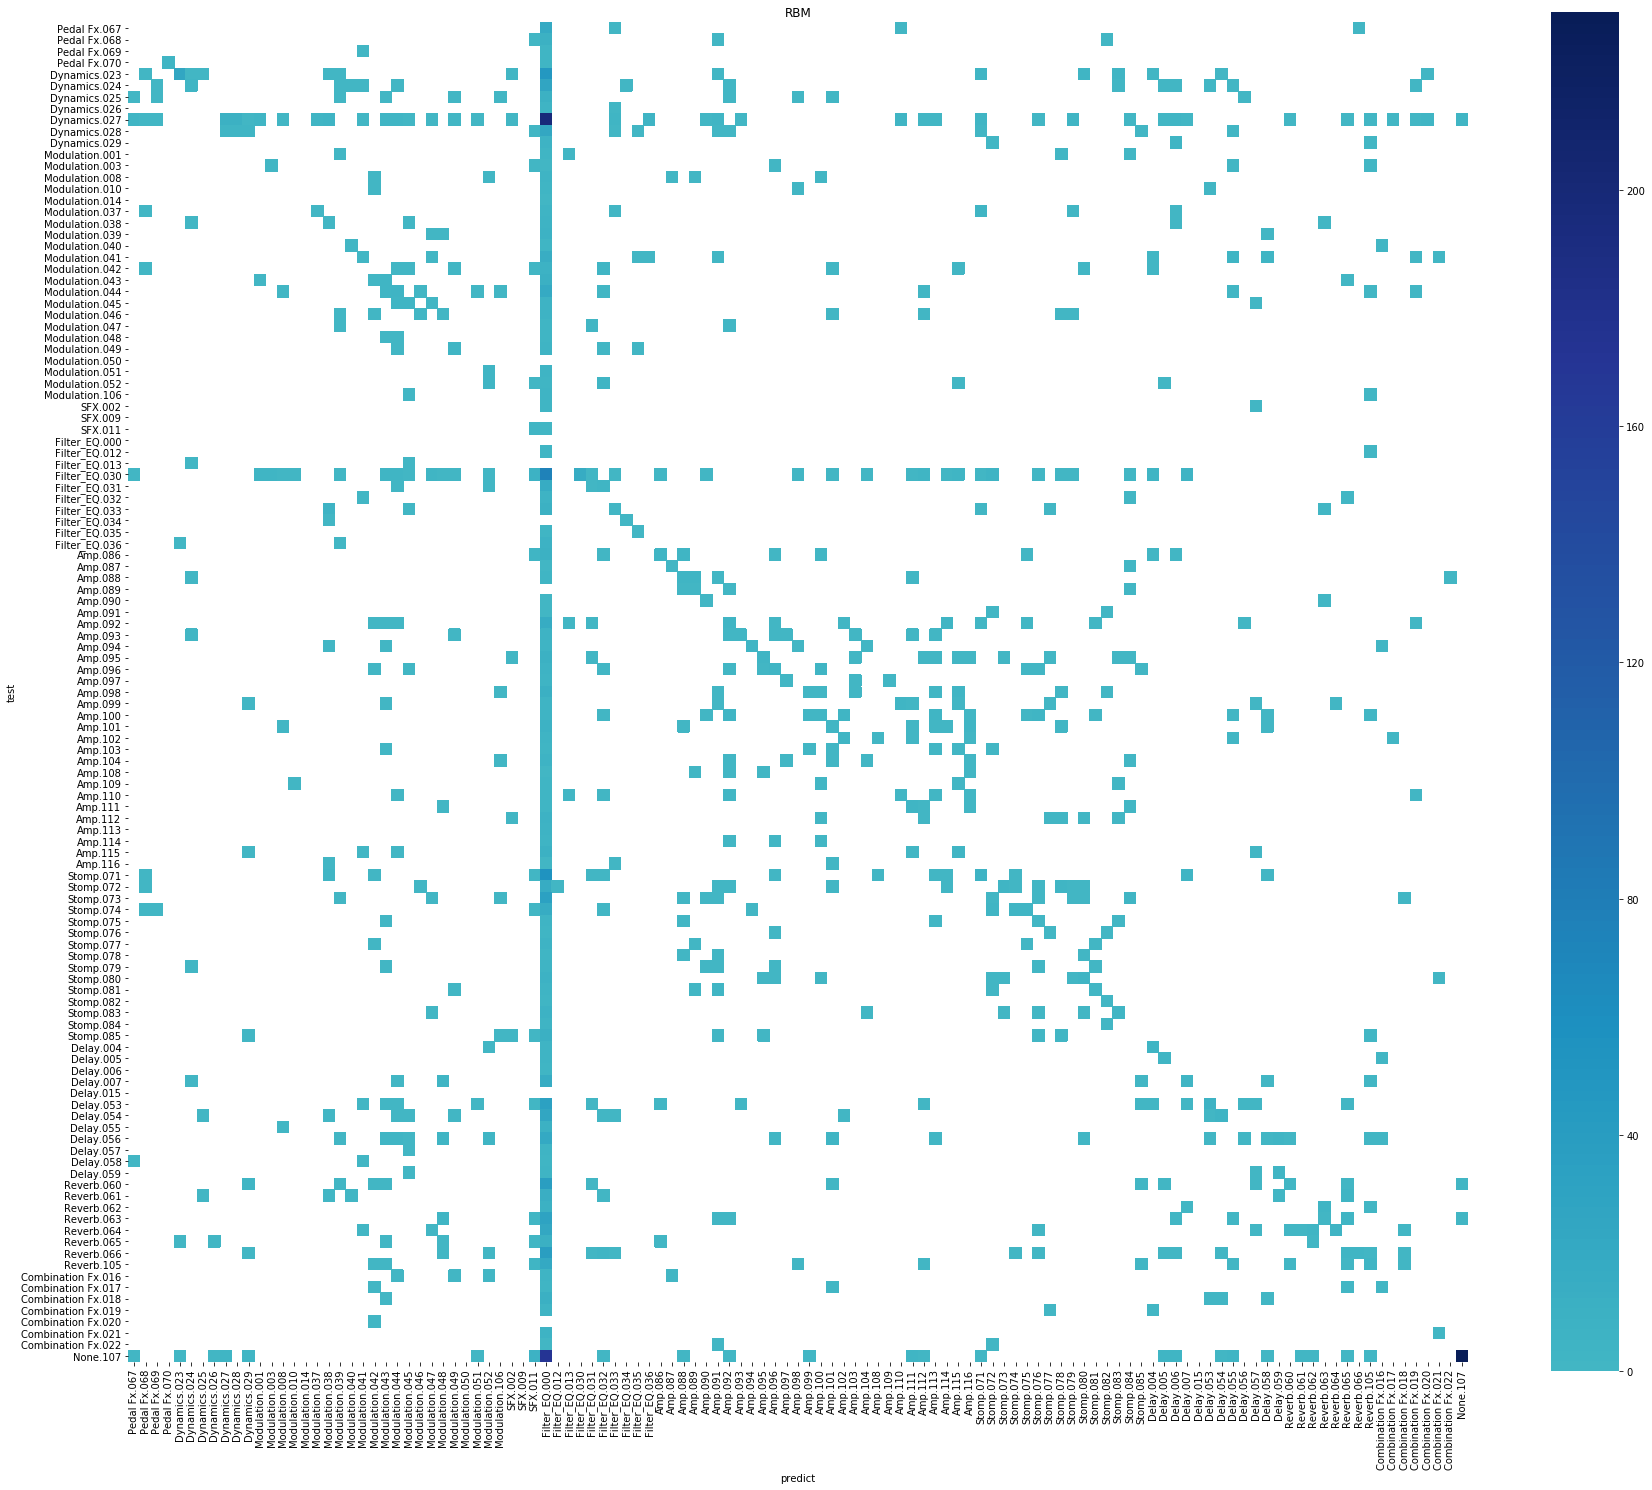

In [21]:
print("Best RBM Free Energy Gap")
model = lambda: RBM(visible_size=total_movies*n_labels, hidden_size=500, learning_rate=Adam(0.05), momentum=0)
plot_rbm_model(model, batch_size=100)

Best RBMCF Best Hit@1 in last eppoch
INFO:tensorflow:Restoring parameters from ../results/model/kfold=0+kfold-intern=0+batch_size=64+class=RBMCF+visible_size=702+hidden_size=1000+regularization=NoRegularization-0.0+learning_rate=Adam-0.001-0.9-0.999-1e-08+sampling_method=CD-1+momentum=0/rbm.ckpt
Verificar se está transposto


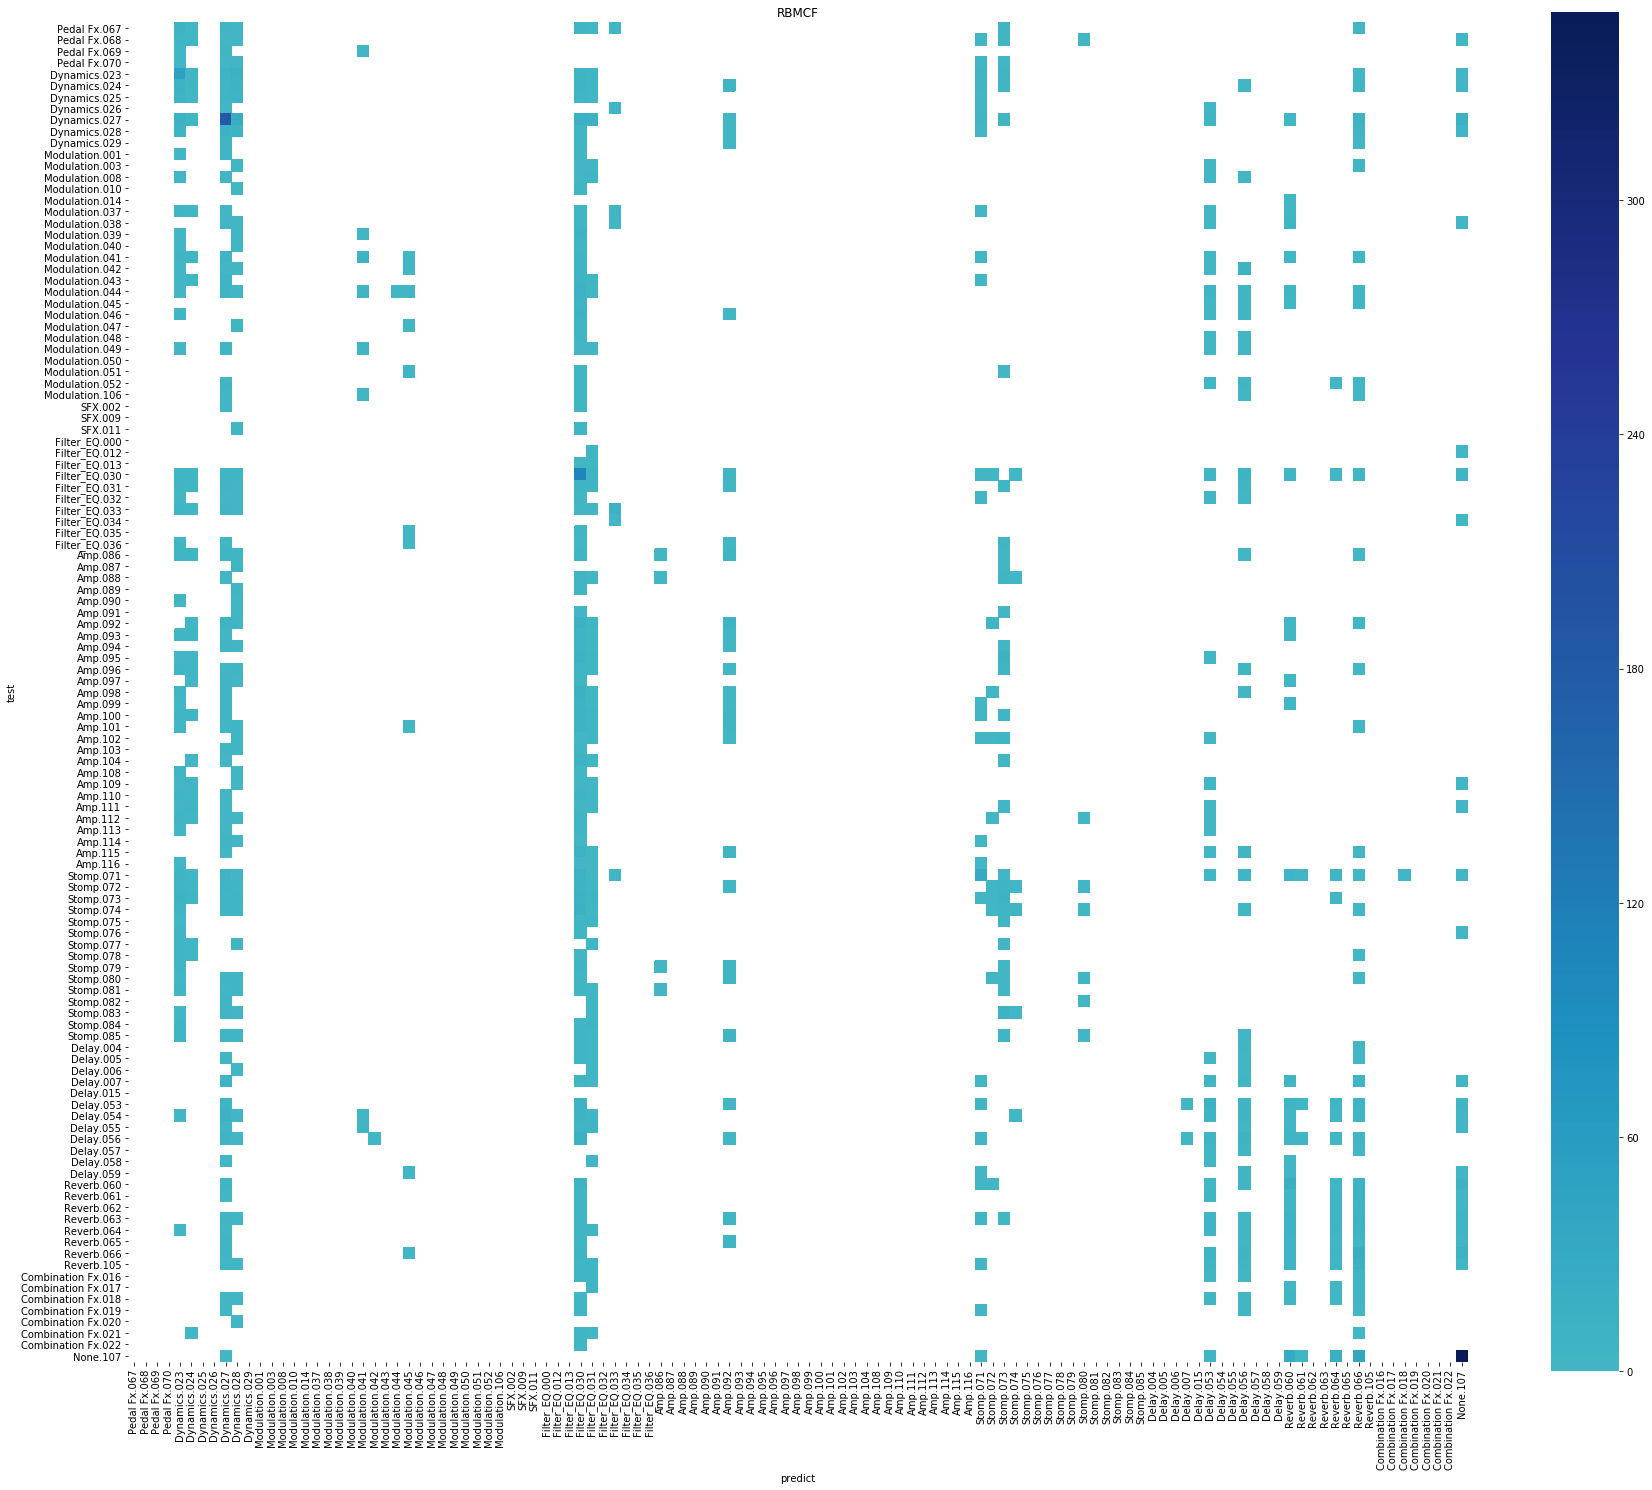

In [22]:
print("Best RBMCF Best Hit@1 in last eppoch")
model = lambda: RBMCF(total_movies, n_labels, hidden_size=1000, learning_rate=Adam(0.001), momentum=0)
plot_rbm_model(model, batch_size=64)

Best RBM Best Hit@1 in last eppoch
INFO:tensorflow:Restoring parameters from ../results/model/kfold=0+kfold-intern=0+batch_size=100+class=RBM+visible_size=702+hidden_size=500+regularization=NoRegularization-0.0+learning_rate=Adam-0.001-0.9-0.999-1e-08+sampling_method=CD-1+momentum=0/rbm.ckpt
Verificar se está transposto


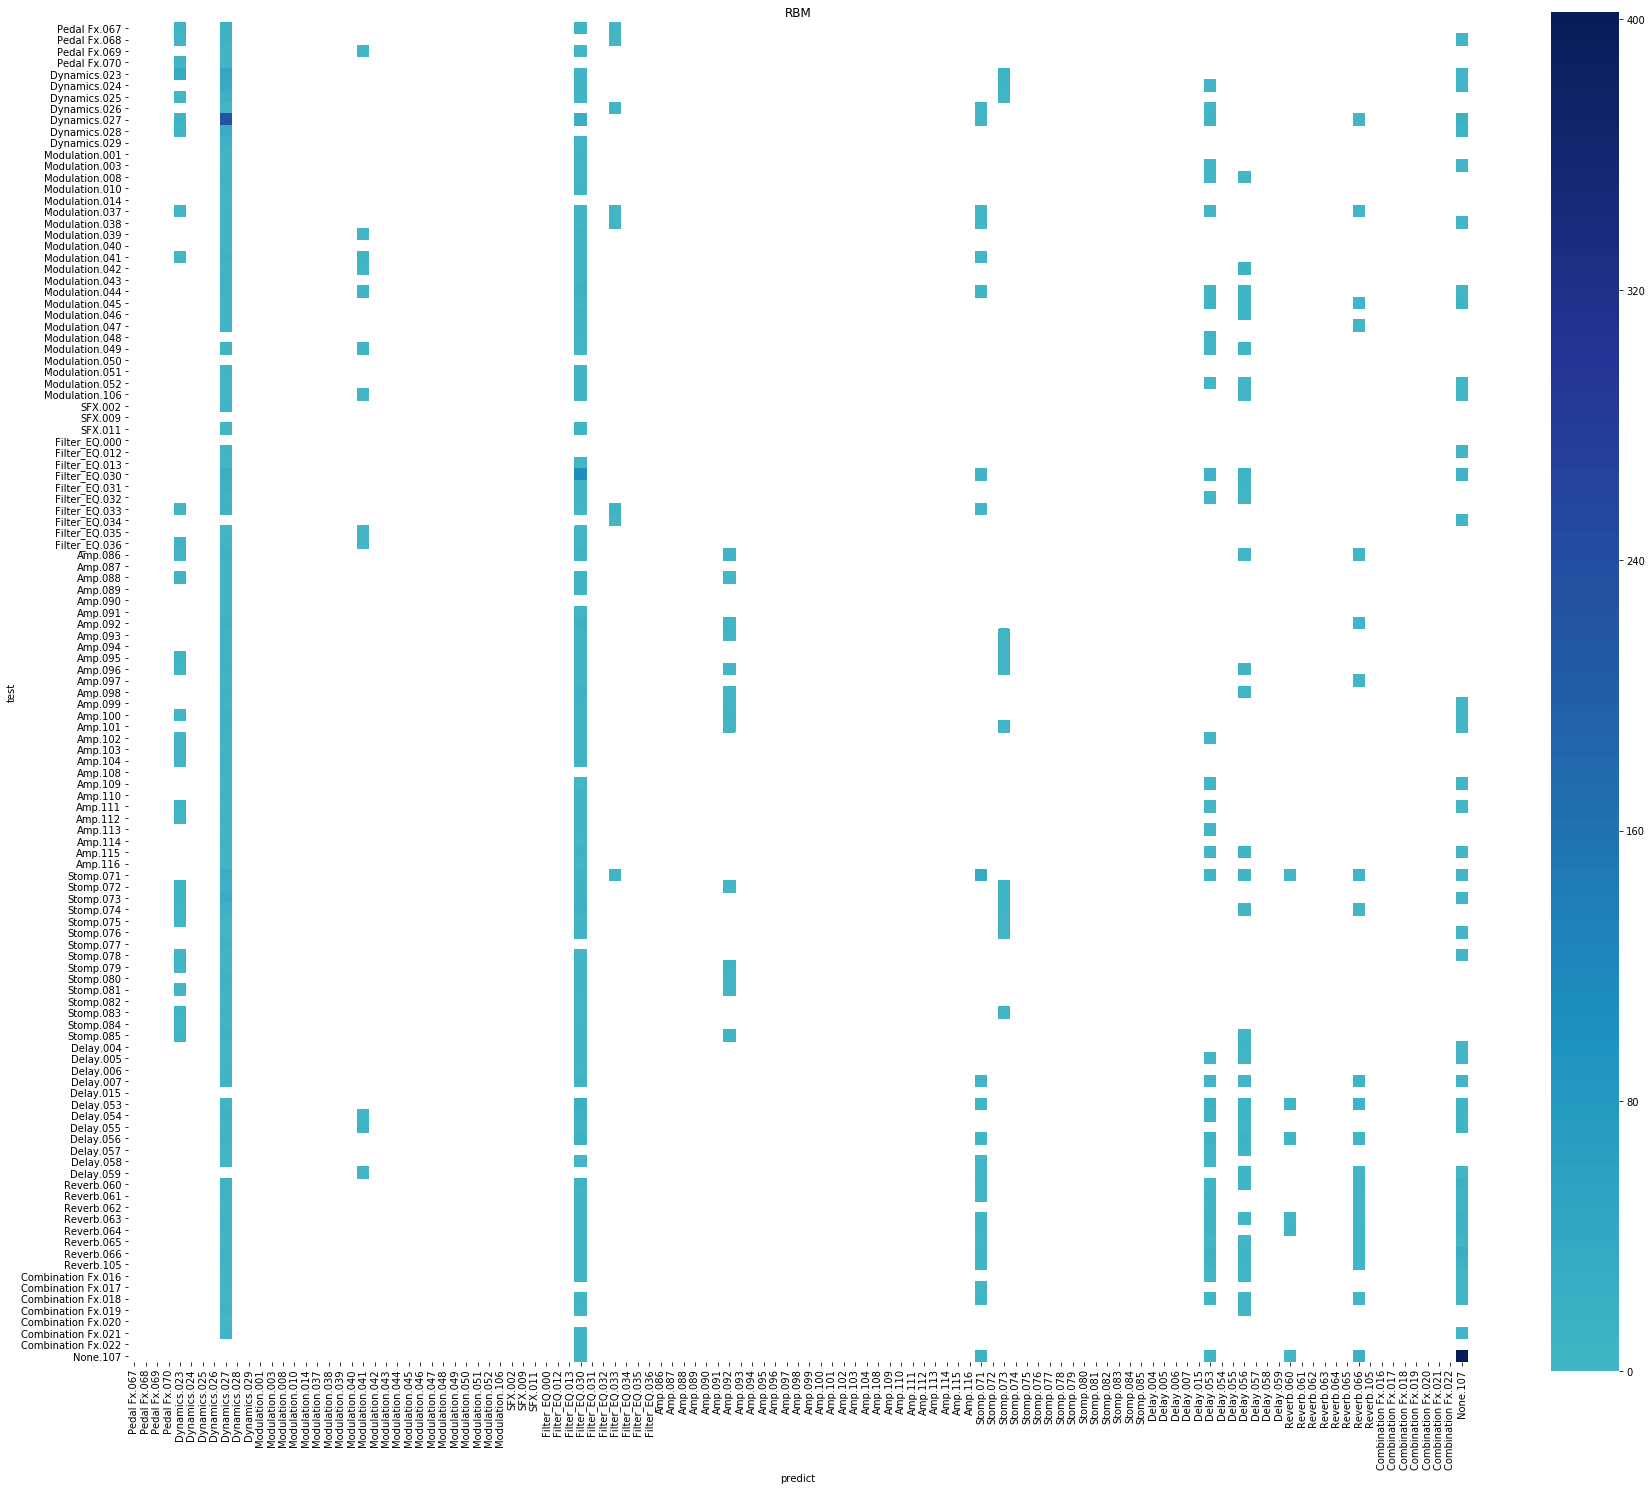

In [23]:
print("Best RBM Best Hit@1 in last eppoch")
model = lambda: RBM(visible_size=total_movies*n_labels, hidden_size=500, learning_rate=Adam(0.001), momentum=0)
plot_rbm_model(model, batch_size=100)

INFO:tensorflow:Restoring parameters from ../results/model/kfold=0+kfold-intern=0+batch_size=64+class=RBM+visible_size=702+hidden_size=500+regularization=NoRegularization-0.0+learning_rate=Adam-0.05-0.9-0.999-1e-08+sampling_method=CD-1+momentum=0/rbm.ckpt
Verificar se está transposto


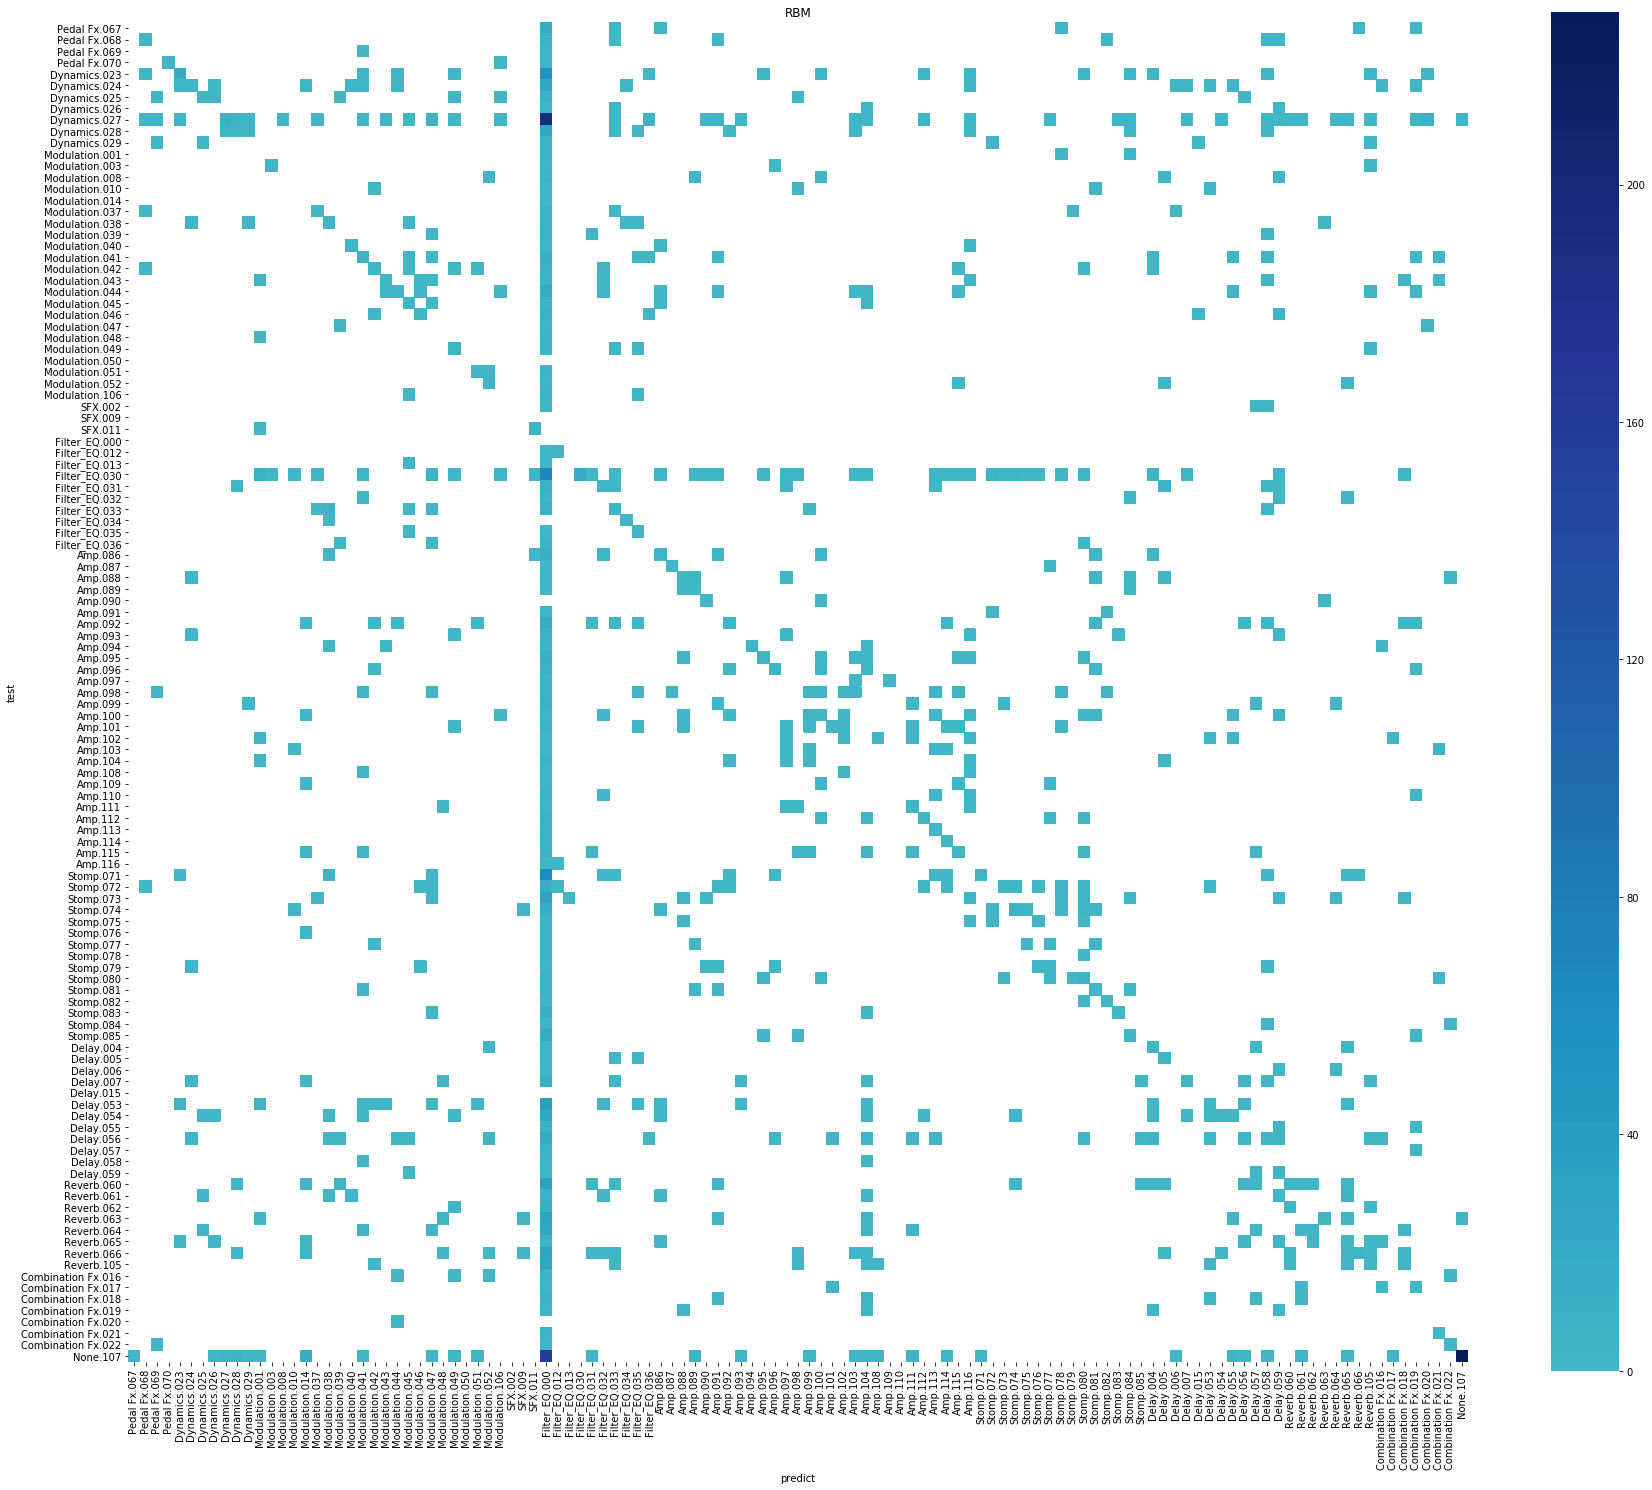

In [97]:
for i, X_trian, X_test in kfolds_training_test.split():
    tf.reset_default_graph()
    
    with tf.Session() as session:
        model = RBM(total_movies*n_labels, hidden_size=500, learning_rate=Adam(0.05), momentum=0)
        model.load(session, f"../results/model/kfold={i}+kfold-intern=0+batch_size={64}+{model.__str__().replace('/', '+')}/rbm.ckpt")

        model = RBMExperiment(model, total_movies)
        
        ys = []
        y_predicts = []

        for i in range(total_movies):
            X, y = Data(X_test.values, total_movies).to_missing_movie(i)

            ys.append(y.argmax(axis=1))
            y_predicts.append(session.run(model.predict(X.T, y_column=i)))
    break

print("Verificar se está transposto")
plot_confusion_matrix(model.model.__class__.__name__, ys, y_predicts, categories.id, categories.new_id)

## Try to show categories only

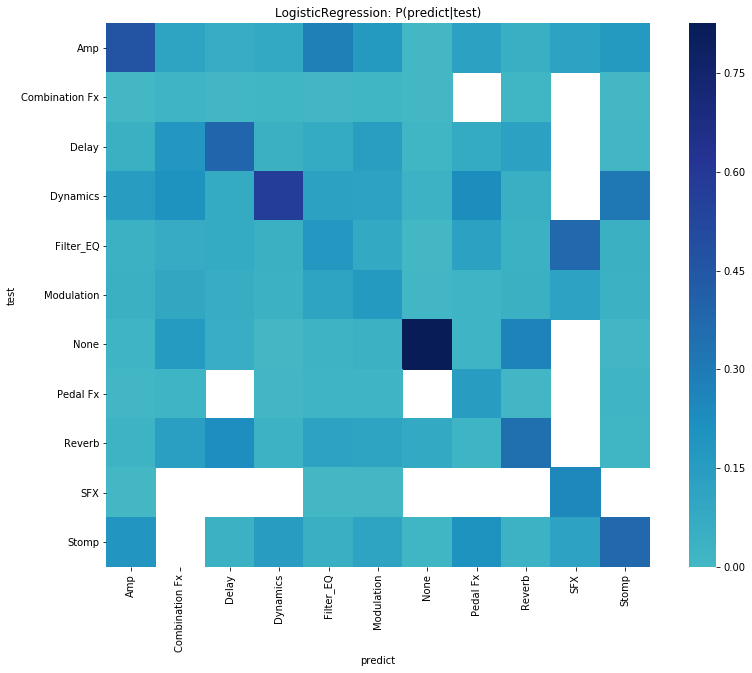

In [55]:
plt.rcParams["figure.figsize"] = [14, 10]

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix2(title: str, y_originals: list, y_predicts: list, columns_order, columns_names):
    matrix = np.zeros(shape=[117, 117])

    for y, y_predict in zip(y_originals, y_predicts):
        matrix += confusion_matrix(y, y_predict, labels=range(117))

    matrix = pd.DataFrame(matrix)
    matrix = matrix[columns_order]
    matrix = matrix.reindex(columns_order)
    matrix.columns = columns_names
    matrix.index = columns_names

    # Group by category
    matrix = matrix.reset_index().groupby('category').sum() \
                 .T.reset_index().groupby('category').sum().T

    matrix = matrix.T/matrix.sum(axis=1).T
    
    mask = matrix == 0

    ax = sns.heatmap(data=matrix, cmap="YlGnBu", center=.01, mask=mask, square=True)
    ax.set_xlabel('predict')
    ax.set_ylabel('test')
    ax.set_title(f'{title}: P(predict|test)')

    return ax

plot_confusion_matrix2(models[2][0].__name__, ys, y_predicts, categories.id, categories.category)